In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer

from ELPH_NVAR import SVDNVAR

In [4]:
runs = ELPH_utils.load_runs(filename='../runs_rand_inits.npz')

runs = runs[::10]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

50 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


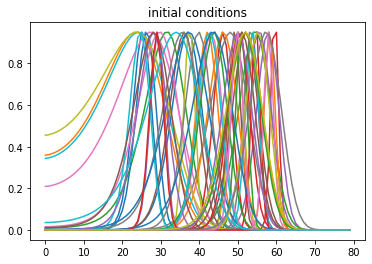

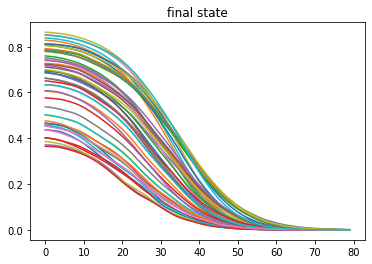

In [5]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 19950)
NVAR state shape:  (861, 19950)
target shape:  (30, 19950)
weights shape:  (861, 30)


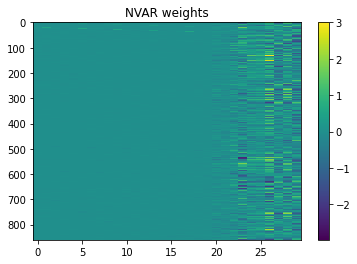

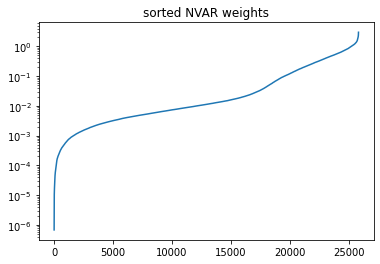

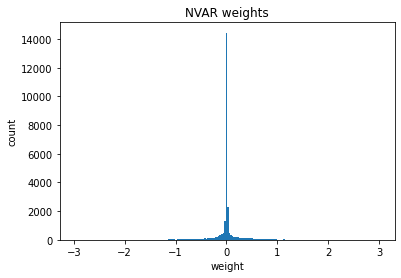

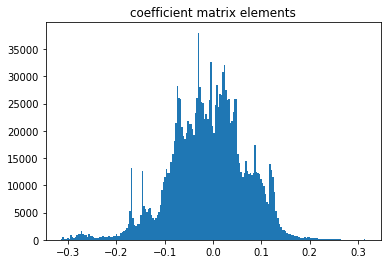

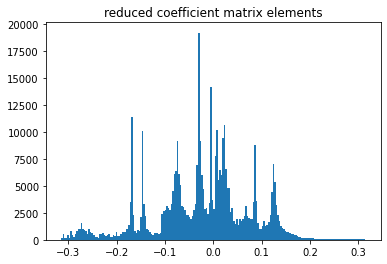

In [6]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)

# scaler = ELPH_Scaler.standardize_scaler()
scaler = ELPH_Scaler.normalize_scaler(0.63)
# scaler = ELPH_Scaler.tanh_scaler(arg_scale=1.0, out_scale=0.3)

NVAR = SVDNVAR(runs)
NVAR.train(rdim=20, prdim = 30, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler)
NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(NVAR.w), bins=200)
plt.title('NVAR weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

plt.hist(np.ravel(NVAR.coef_matrix), bins=200)
plt.title('coefficient matrix elements')
plt.show()

plt.hist(np.ravel(NVAR.coef_matrix[:NVAR.rdim]), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

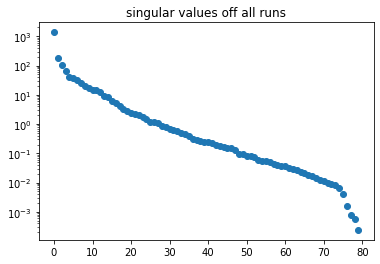

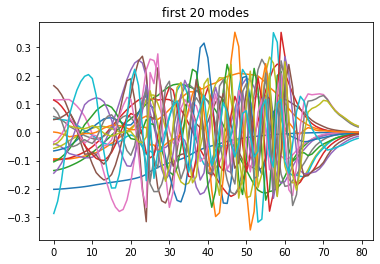

In [18]:
plt.semilogy(NVAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(NVAR.rdim):
  plt.plot(NVAR.U[:,l],  label='U_'+str(l))
plt.title('first ' + str(NVAR.rdim) + ' modes')
plt.show()

In [8]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)
scaler = ELPH_Scaler.normalize_scaler(0.63)

train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'NVAR_p':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler}
score_kwargs = {'norm':'max', 'errSVD':False}

m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)


nan
nan
[0.030299890597463196, nan, nan, 0.08638254106370032, 0.05418695203999645]


In [20]:
def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)
    
    train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'NVAR_p':2, 'intercept':True, 'optimizer':optimizer, 'scaler':scaler, 'full_hist':False}
    score_kwargs = {'norm':'max', 'errSVD':False}
    
    m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,0.7]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   |   aExp    | rel_scale |
-------------------------------------------------
|  1        | -0.02337  | -3.007    |  0.2551   |
|  2        | -0.01707  | -4.485    |  0.2465   |
|  3        | -0.0232   | -2.094    |  0.4818   |
|  4        | -0.02285  | -2.661    |  0.3431   |
|  5        | -0.03033  | -3.044    |  0.1049   |
|  6        | -0.01587  | -3.43     |  0.6277   |
|  7        | -0.02008  | -2.31     |  0.6173   |
|  8        | -0.02138  | -2.332    |  0.5143   |
|  9        | -0.0184   | -3.123    |  0.4563   |
|  10       | -0.02337  | -2.053    |  0.4857   |
|  11       | -0.01587  | -3.433    |  0.6304   |
|  12       | -0.01597  | -3.792    |  0.494    |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:221: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


|  13       | -10.0     | -4.195    |  0.6181   |
|  14       | -0.02172  | -4.911    |  0.1      |
|  15       | -0.02676  | -3.639    |  0.1003   |
|  16       | -0.0184   | -3.122    |  0.4562   |
|  17       | -0.05493  | -1.314    |  0.1      |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:221: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


|  18       | -10.0     | -1.001    |  0.7      |
|  19       | -0.04445  | -1.815    |  0.1      |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:221: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


|  20       | -10.0     | -5.0      |  0.7      |
|  21       | -0.02459  | -4.159    |  0.1      |
|  22       | -0.03831  | -2.348    |  0.1      |
|  23       | -0.02306  | -4.583    |  0.1      |
|  24       | -0.01703  | -2.76     |  0.7      |
|  25       | -0.02247  | -1.719    |  0.7      |
|  26       | -0.02941  | -1.596    |  0.3472   |
|  27       | -0.01809  | -3.559    |  0.3641   |
|  28       | -0.07031  | -1.0      |  0.1      |
|  29       | -0.03826  | -2.351    |  0.1001   |
|  30       | -0.01601  | -3.104    |  0.7      |
|  31       | -0.02117  | -3.874    |  0.2004   |
|  32       | -0.0337   | -2.75     |  0.1009   |
|  33       | -0.02081  | -2.007    |  0.6943   |
|  34       | -0.02744  | -3.329    |  0.1136   |
|  35       | -0.04772  | -1.593    |  0.1026   |
|  36       | -0.02383  | -4.375    |  0.1002   |
|  37       | -0.02746  | -1.808    |  0.3546   |
|  38       | -0.01801  | -2.526    |  0.7      |
|  39       | -0.0378   | -1.578    |  0.1873   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:221: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


|  63       | -10.0     | -3.67     |  0.7      |
|  64       | -0.01632  | -3.565    |  0.4943   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:221: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


|  65       | -10.0     | -5.0      |  0.2705   |
|  66       | -0.04072  | -1.011    |  0.2872   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:221: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


|  67       | -10.0     | -4.608    |  0.4211   |
|  68       | -0.01801  | -4.062    |  0.2713   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:221: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec
incl/ELPH_NVAR.py:221: RuntimeWarning: overflow encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec
incl/ELPH_Scaler.py:55: RuntimeWarning: overflow encountered in multiply
  return ( ( (data_matrix.T + 0.5*self.rel_scale) * self.scale[:n_features])+self.min[:n_features] ).T


|  69       | -10.0     | -4.222    |  0.6402   |
|  70       | -0.01823  | -4.262    |  0.2332   |
|  71       | -0.01873  | -2.928    |  0.4927   |
|  72       | -0.02329  | -1.841    |  0.573    |
|  73       | -0.02335  | -2.831    |  0.2867   |
|  74       | -0.02379  | -3.175    |  0.2151   |
|  75       | -0.02477  | -1.654    |  0.5547   |
|  76       | -0.03033  | -1.07     |  0.5435   |
|  77       | -0.03135  | -1.171    |  0.44     |
|  78       | -0.03386  | -1.0      |  0.4384   |
|  79       | -0.02564  | -1.312    |  0.684    |
|  80       | -0.0164   | -3.683    |  0.4522   |
|  81       | -0.01663  | -3.913    |  0.3757   |
|  82       | -0.01706  | -4.485    |  0.2469   |
|  83       | -0.03688  | -1.436    |  0.2275   |
|  84       | -0.02185  | -2.621    |  0.4017   |
|  85       | -0.03208  | -2.9      |  0.1015   |
|  86       | -0.02834  | -1.217    |  0.5582   |
|  87       | -0.0344   | -1.309    |  0.3041   |
|  88       | -0.0212   | -3.644    |  0.2297   |


In [9]:
# scores = []

# k = 1

# for aExp in np.linspace(-4,-2,15):
#     for rs in np.linspace(0.2,0.5,15):
#         print(k)
#         scores.append(get_score(aExp,rs))
#         k += 1

In [10]:
# scrs = np.array(scores)
# scrs = np.reshape(scrs,(15,15))


# plt.imshow(scrs, aspect='auto', origin='lower', vmin=-0.02, extent=[0.2,0.5,-4,-2])
# plt.colorbar()
# plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 199101)
NVAR state shape:  (861, 199101)
target shape:  (30, 199101)
weights shape:  (861, 30)
NVAR error:  0.0718163364108495
NVAR error compared to SVD approximated run:  0.10787979819329838


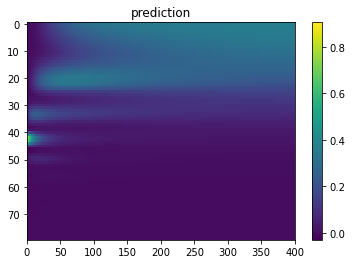

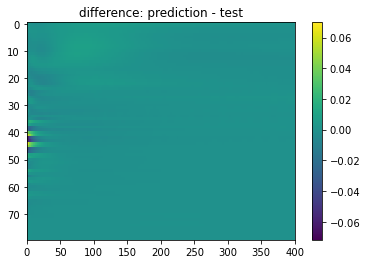

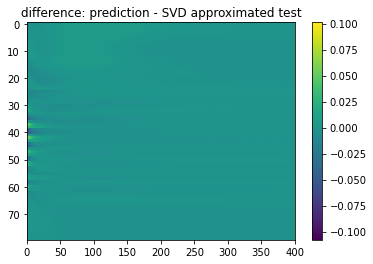

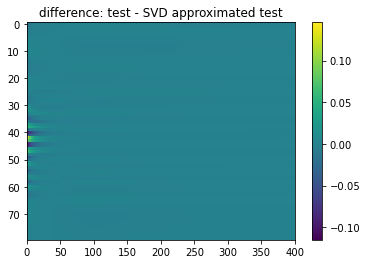

In [26]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)
scaler = ELPH_Scaler.normalize_scaler(0.63)

column_weights = 1.0 + 0.*np.exp(-10.*np.linspace(0,1,runs[0].shape[1]))

train_runs = runs[::1]
test_run = train_runs.pop(85)

NVAR.load_runs(train_runs)
NVAR.train(rdim=20, prdim=30, n_VAR_steps=2, NVAR_p=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, column_weights=column_weights)

NVAR.print_status()


print('NVAR error: ', NVAR.get_error(test_run, norm='max') )
print('NVAR error compared to SVD approximated run: ', NVAR.get_error(test_run, norm='max', errSVD=True) )

pred = NVAR.predict_single_run(test_run)
test_run_SVDapprx = NVAR.U_rdim @ NVAR.U_rdim.T @ test_run


xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()


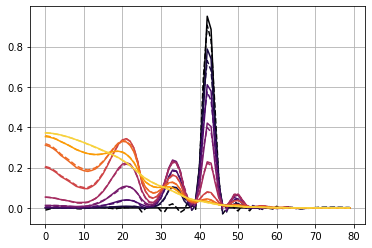

In [27]:
colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))

plt.show()

NVAR std error:  0.003001019770811825
NVAR max abs error:  0.0718163364108495


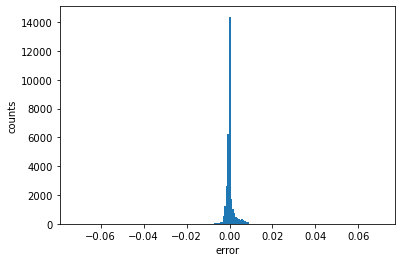

In [28]:
print('NVAR std error: ', NVAR.get_error(test_run, pred, norm='std') )
print('NVAR max abs error: ', NVAR.get_error(test_run, pred, norm='max') )

plt.hist(np.ravel(pred-test_run), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()
